In [1]:
%cd ../../..

/Users/ericrobertbrewer/Code/BYU/Suitability/book-analyzer


# bookcave_meta

[General FAQ](https://mybookcave.com/reader-faq/)

[BookCave rating system](https://mybookcave.com/reader-faq/what-makes-a-book-earn-a-particular-content-rating/)

## Set Up

In [2]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

from python import folders
from python.util import shared_parameters
from python.sites.bookcave import bookcave

Using TensorFlow backend.


Plot label distributions.

In [3]:
ratings = ['All Ages', 'Mild', 'Mild+', 'Moderate', 'Moderate+', 'Adult', 'Adult+']
rating_to_index = {rating: i for i, rating in enumerate(ratings)}
rating_colors = ['royalblue', 'mediumseagreen', 'darkseagreen', 'yellowgreen', 'yellow', 'orange', 'orangered']
# rating_text_colors = ['w', 'w', 'k', 'k', 'k', 'k', 'w']


def autolabel(ax, bars, text_color):
    heights = [bar.get_height() for bar in bars]
    max_height = max(heights)
    for i, bar in enumerate(bars):
        height = heights[i]
        is_max = height == max_height
        ax.text(bar.get_x() + bar.get_width()/2.,
                height - .05 * max_height if is_max else height + .05 * max_height,
                '{}'.format(int(height)),
                ha='center',
                va='top' if is_max else 'bottom',
                color=text_color if is_max else 'k')


def plot_label_distribution(x, labels, title, ylabel, color, xtheta=45, xha='right', text_color='k', save=None, figsize=None):
    bincount = np.bincount(labels)
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(x, bincount, color=color)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(x, rotation=xtheta, ha=xha)
    autolabel(ax, bars, text_color)
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    plt.show()
    return bincount


def print_label_distribution(x, labels, bincount=None):
    longest_name = max(len(name) for name in x)
    if bincount is None:
        bincount = np.bincount(labels)
    for index, name in enumerate(x):
        spaces = ' ' * (longest_name - len(name))
        p = bincount[index]/len(labels)
        tens_digit_space = ' ' if p < .1 else ''
        print('{}`{}`: {}{:.3%}'.format(spaces, name, tens_digit_space, p))

## Metadata

Read all of the data and metadata from the BookCave database.

In [4]:
subset_ratio = shared_parameters.DATA_SUBSET_RATIO
subset_seed = shared_parameters.DATA_SUBSET_SEED
min_len = shared_parameters.DATA_PARAGRAPH_MIN_LEN
max_len = shared_parameters.DATA_PARAGRAPH_MAX_LEN
min_tokens = shared_parameters.DATA_MIN_TOKENS
categories_mode = shared_parameters.DATA_CATEGORIES_MODE
_, Y, categories, category_levels, book_ids, books_df, ratings_df, levels_df, categories_df = \
    bookcave.get_data({'paragraph_tokens'},
                      subset_ratio=subset_ratio,
                      subset_seed=subset_seed,
                      min_len=min_len,
                      max_len=max_len,
                      min_tokens=min_tokens,
                      categories_mode=categories_mode,
                      return_meta=True)

Index book IDs to use later.

In [5]:
book_id_to_index = {book_id: i for i, book_id in enumerate(book_ids)}

### Books

Count the number of books which are rated and for which the book text has been scraped.

In [6]:
len(books_df)

6395

See some samples of book data.

In [7]:
books_df.head(3)

,id,title,authors,summary,description,community_ratings_count,community_average_rating,pages,genres,amazon_kindle_url,...,audible_url,apple_books_url,barnes_and_noble_url,barnes_and_noble_audiobook_url,barnes_and_noble_print_url,google_play_url,kobo_url,smashwords_url,last_updated,asin
1,%d1%81orridors-part-before-thriller-romance-1,Сorridors: Part Before (Talisman (Artefact) Bo...,Valerii Titov,The era of ordinary mankind has come to an end...,University of Chicago final year planetology s...,1,Adult,122.0,Fiction/Thrillers,https://mybookcave.com/t/?u=0&b=68286&r=86&sid...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540420100854,B078QV11T6
8,10-habits-of-highly-effective-people,10 Habits of Highly Effective People,A. I. Abana,A tried and proven approach to business succes...,They set targets . . . they achieve them; they...,1,All Ages,208.0,Nonfiction/Self-help,https://mybookcave.com/t/?u=0&b=116413&r=86&si...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1557934157117,B07RGRTPFN
9,10-minute-herbal-recipes-for-weight-loss-and-b...,10 Minute Herbal Recipes for Weight Loss and B...,Alvina Ng,You know very well that you will gain weight w...,No time to cook? Not eating enough healthy foo...,1,All Ages,114.0,Nonfiction/Cooking,https://mybookcave.com/t/?u=0&b=24924&r=86&sid...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1540483924525,B01JDD6LR0


#### Overall Ratings

View the distribution of overall (average) ratings for books with text.

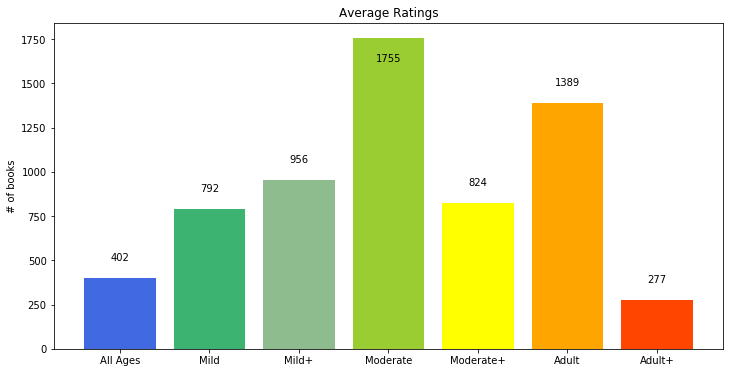

 `All Ages`:  6.286%
     `Mild`: 12.385%
    `Mild+`: 14.949%
 `Moderate`: 27.443%
`Moderate+`: 12.885%
    `Adult`: 21.720%
   `Adult+`:  4.332%


In [8]:
def plot_and_print_average_ratings_distribution(books_df, figsize=(12, 6)):
    average_ratings = list(books_df['community_average_rating'])
    # Transform string label to integer.
    labels = [rating_to_index[rating] for rating in average_ratings]
    title = 'Average Ratings'
    ylabel = '# of books'
    color = rating_colors
    save = os.path.join(folders.FIGURES_PATH, 'kindle_community_average_ratings')
    bincount = plot_label_distribution(ratings, labels, title, ylabel, color,
                                       xtheta=0,
                                       xha='center',
                                       save=save,
                                       figsize=figsize)
    print_label_distribution(ratings, labels, bincount=bincount)
    return bincount

_ = plot_and_print_average_ratings_distribution(books_df)

#### Genres

Analyze distribution of genres.

In [9]:
book_genre_values = books_df['genres'].fillna(value='None').values
book_genres = [value.split('|') for value in book_genre_values]
book_genre_hierarchies = [[genre.split('/') for genre in genres] for genres in book_genres]

root_genres = ['Juvenile Fiction',
               'Young Adult Fiction',
               'Fiction',
               'Juvenile Nonfiction',
               'Young Adult Nonfiction',
               'Nonfiction',
               'None']
root_genre_to_index = {root_genre: i for i, root_genre in enumerate(root_genres)}
root_genre_y = []
root_genre_category_y = []
for i, book_genre_hierarchy in enumerate(book_genre_hierarchies):
    for hierarchy in book_genre_hierarchy:
        root_genre_y.append(root_genre_to_index[hierarchy[0]])
        root_genre_category_y.append(Y[:, i])

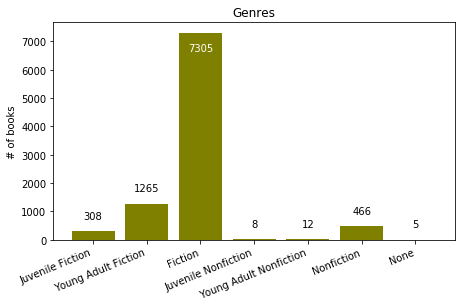

In [10]:
root_genre_bincount = plot_label_distribution(root_genres, root_genre_y, 'Genres', '# of books', 'olive', xtheta=22.5, text_color='w', figsize=(7.2, 4))

In [11]:
root_genre_category_count = [[{level_index: 0 for level_index in range(len(category_levels[j]))}.copy()
                              for j in range(len(categories))]
                             for _ in range(len(root_genres))]
for genre_index, category_y in list(zip(root_genre_y, root_genre_category_y)):
    for j, value in enumerate(category_y):
        root_genre_category_count[genre_index][j][value] += 1

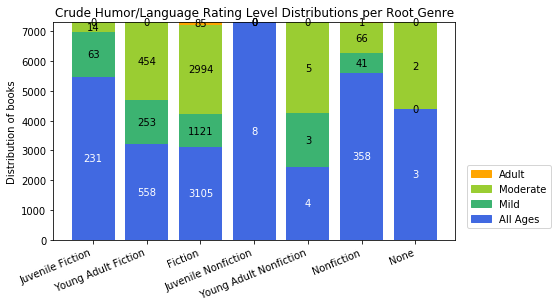

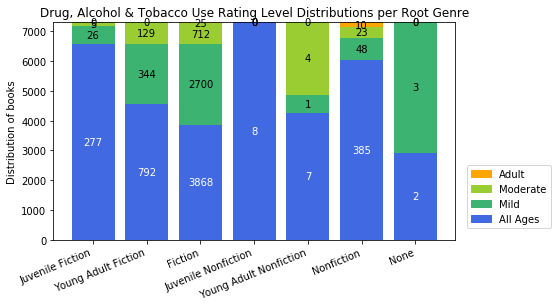

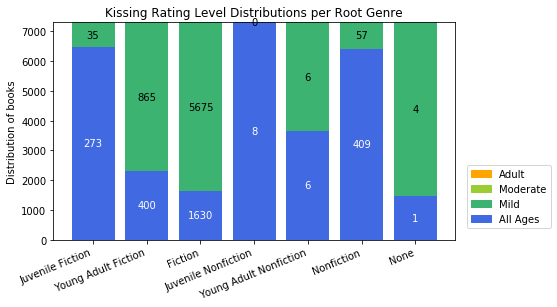

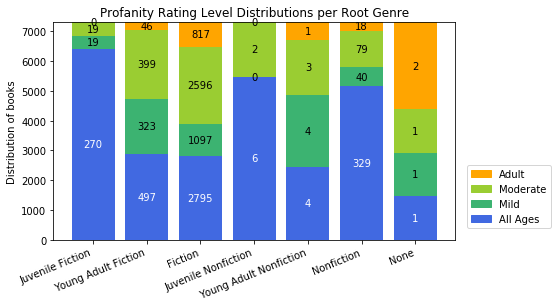

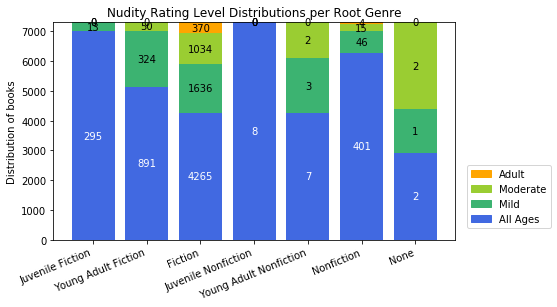

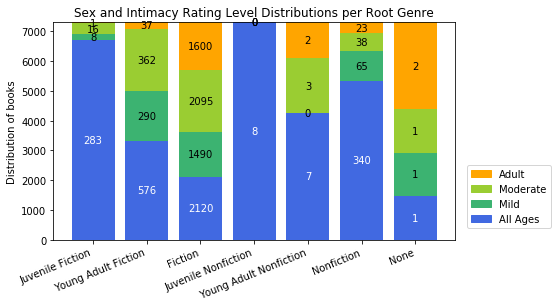

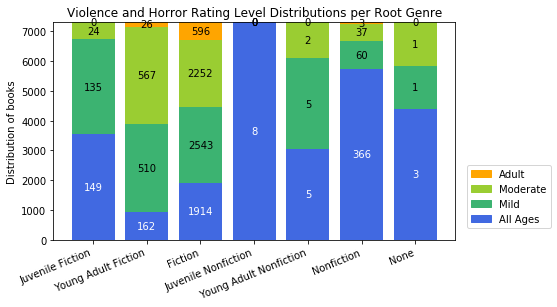

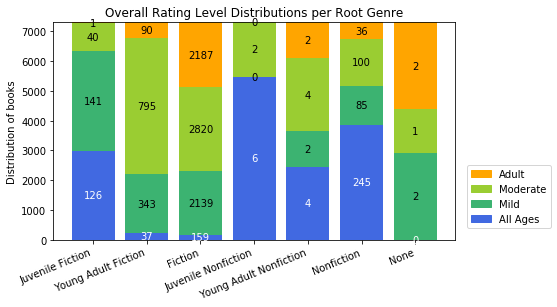

In [12]:
def plot_rating_per_genre_per_category(root_genre_category_count, root_genre_bincount, figsize=(7.2, 4)):
    max_genre_count = max(root_genre_bincount)
    
    for j, category in enumerate(categories):
        fig, ax = plt.subplots(figsize=figsize)
        for genre_index, category_count in enumerate(root_genre_category_count):
            overall_ratings = bookcave.CATEGORY_LEVELS[categories_mode][bookcave.CATEGORY_INDEX_OVERALL]
            # Get rating-associated colors.
            if j == bookcave.CATEGORY_INDEX_OVERALL:
                colors = [rating_colors[rating_to_index[rating]] for rating in overall_ratings]
            else:
                category_level_df = categories_df[categories_df['category'].str.match(category)]
                colors = [rating_colors[rating_to_index[row['rating']]]
                          for _, row in category_level_df.iterrows()]

            # Add label counts cumulatively.
            _sum = 0
            for i in range(len(category_levels[j])):
                value = category_count[j][i]
                scaled_value = value * max_genre_count / root_genre_bincount[genre_index]
                bar = ax.bar(genre_index, scaled_value, bottom=_sum, color=colors[i])[0]
                ax.text(bar.get_x() + bar.get_width()/2.,
                        _sum + bar.get_height() / 2,
                        '{}'.format(value),
                        ha='center',
                        va='center',
                        color='w' if i is 0 else 'k')
                _sum += scaled_value

        ax.set_title('{} Rating Level Distributions per Root Genre'.format(bookcave.CATEGORY_NAMES[category]))
        ax.set_ylabel('Distribution of books')
        xlabels = [''] + root_genres
        ax.set_xticklabels(xlabels, rotation=22.5, ha='right')
        plt.legend(handles=[mpatches.Patch(color=rating_colors[rating_to_index[rating]], label=rating)
                            for rating in reversed(overall_ratings)],
                   loc='center right',
                   bbox_to_anchor=(1.25, 0.2))
        plt.show()
        
plot_rating_per_genre_per_category(root_genre_category_count, root_genre_bincount)

Plot distribution of all genres under `Fiction`.

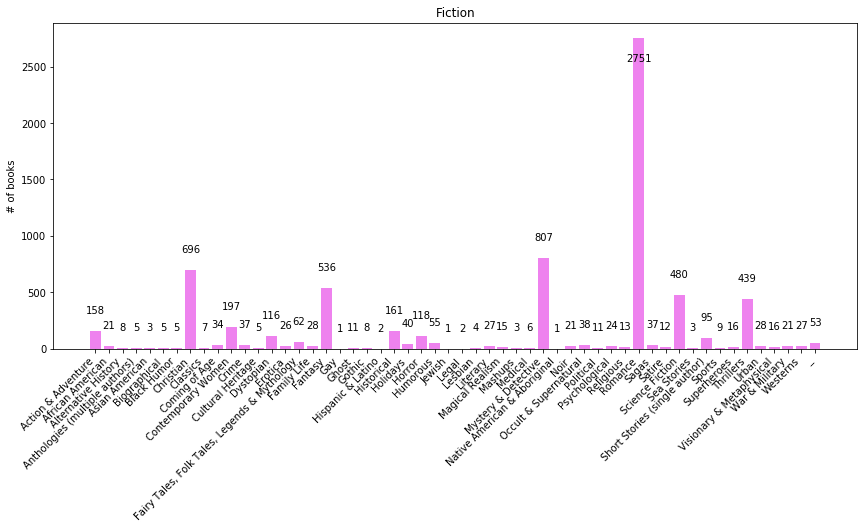

In [13]:
fiction_genres_set = set()
fiction_genre_values = []
for book_genre_hierarchy in book_genre_hierarchies:
    for hierarchy in book_genre_hierarchy:
#         if hierarchy[0] != 'Juvenile Fiction'\
#         and hierarchy[0] != 'Young Adult Fiction'\
#         and hierarchy[0] != 'Fiction':
        if hierarchy[0] != 'Fiction':
            continue
        sub_genre = hierarchy[1] if len(hierarchy) > 1 else '_'
        fiction_genres_set.add(sub_genre)
        fiction_genre_values.append(sub_genre)
fiction_genres = sorted(list(fiction_genres_set))
fiction_genre_to_index = {genre: i for i, genre in enumerate(fiction_genres)}
fiction_genre_y = [fiction_genre_to_index[value] for value in fiction_genre_values]

fiction_genres_bincount = plot_label_distribution(fiction_genres,
                                                  fiction_genre_y,
                                                  'Fiction',
                                                  '# of books',
                                                  'violet',
                                                  text_color='k',
                                                  figsize=(14.4, 6))

In [14]:
fiction_romance_count = fiction_genres_bincount[fiction_genre_to_index['Romance']]
print('{:.2%} ({:d}/{:d}) of all genres are `Fiction/Romance`.'.format(fiction_romance_count / len(root_genre_y),
                                                                       fiction_romance_count,
                                                                       len(root_genre_y)))
print('{:.2%} ({:d}/{:d}) of `Fiction` genres are `Romance`.'.format(fiction_romance_count / len(fiction_genre_y),
                                                                     fiction_romance_count,
                                                                     len(fiction_genre_y)))

29.36% (2751/9369) of all genres are `Fiction/Romance`.
37.66% (2751/7305) of `Fiction` genres are `Romance`.


Plot distribution of `Fiction/Romance` novels.

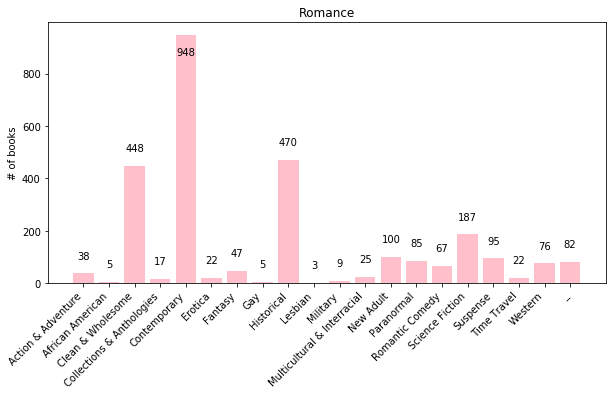

In [15]:
romance_genres_set = set()
romance_genre_values = []
for book_genre_hierarchy in book_genre_hierarchies:
    for hierarchy in book_genre_hierarchy:
        if len(hierarchy) < 2:
            continue
        if hierarchy[0] != 'Fiction' or hierarchy[1] != 'Romance':
            continue
        sub_sub_genre = hierarchy[2] if len(hierarchy) > 2 else '_'
        romance_genres_set.add(sub_sub_genre)
        romance_genre_values.append(sub_sub_genre)
romance_genres = sorted(list(romance_genres_set))
romance_genre_to_index = {genre: i for i, genre in enumerate(romance_genres)}
romance_genre_y = [romance_genre_to_index[value] for value in romance_genre_values]

romance_genres_bincount = plot_label_distribution(romance_genres,
                                                  romance_genre_y,
                                                  'Romance',
                                                  '# of books',
                                                  'pink',
                                                  text_color='k',
                                                  figsize=(10, 4.8))

### Rating Levels

Count the total number of rating levels (which belong to categories) given to books.

In [16]:
len(levels_df)

27186

See some examples of rating levels.

In [17]:
levels_df.head()

,book_id,rating,title,count
8,%d1%81orridors-part-before-thriller-romance-1,Adult,Passionate kissing,1
9,%d1%81orridors-part-before-thriller-romance-1,Adult,Moderate profanity (41 to 100),1
10,%d1%81orridors-part-before-thriller-romance-1,Adult,Moderate crude humor/language,1
11,%d1%81orridors-part-before-thriller-romance-1,Adult,Some violence or horror,1
12,%d1%81orridors-part-before-thriller-romance-1,Adult,Detailed onscreen love scenes,1


### Categories

Many levels are mutually exclusive for a particular book. They are grouped into content 'categories'.

In [18]:
len(categories_df)

26

See examples of categorized rating levels.

In [19]:
categories_df.head(9)

,category,level,rating,description
0,crude_humor_language,None,All Ages,None or minimal (appropriate for young children)
1,crude_humor_language,Mild crude humor,Mild,Mild (fart jokes or similar)
2,crude_humor_language,Moderate crude humor/language|Significant crud...,Moderate,Moderate (appropriate for teens)|Significant (...
3,crude_humor_language,Extensive crude humor/language,Adult,"Graphic, extensive, and continuous"
4,drug_alcohol_tobacco_use,None,All Ages,None or small mention of use by adults only
5,drug_alcohol_tobacco_use,Mild substance use|Some substance use,Mild,Mild use by adults only|Average use by adults ...
6,drug_alcohol_tobacco_use,Moderate substance use by adults and/or some u...,Moderate,Moderate by adults and/or some use by minors|S...
7,drug_alcohol_tobacco_use,Extensive substance abuse,Adult,Extensive substance abuse
8,kissing,None,All Ages,None or quick peck


View the list of unique category names.

In [20]:
categories

['crude_humor_language',
 'drug_alcohol_tobacco_use',
 'kissing',
 'profanity',
 'nudity',
 'sex_and_intimacy',
 'violence_and_horror',
 'overall']

## Labels

See an example of book rating levels.

In [21]:
book_ids[42]

'a-brush-with-vampires'

In [22]:
Y[:, 42]

array([0, 2, 1, 2, 1, 1, 2, 2], dtype=int32)

See how the vector of average rating levels per category is represented.

In [23]:
[(i, category_levels[j][i]) for j, i in enumerate(Y[:, 42])]

[(0, 'None'),
 (2,
  'Moderate substance use by adults and/or some use by minors|Significant substance use'),
 (1, 'Mild kissing|Passionate kissing'),
 (2, 'Some profanity (6 to 40)|Moderate profanity (41 to 100)'),
 (1, 'Brief (nonsexual) nudity|Brief nudity'),
 (1, 'Mild sensuality'),
 (2, 'Moderate violence or horror'),
 (2, 'Moderate')]

Plot the label distribution for each category.

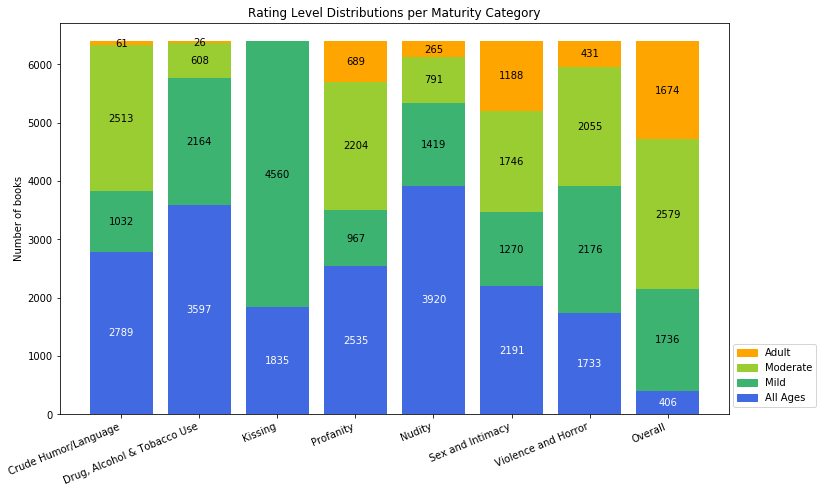

In [24]:
def plot_and_print_label_distributions():
    fig, ax = plt.subplots(figsize=(12, 7.2))
    overall_ratings = bookcave.CATEGORY_LEVELS[categories_mode][bookcave.CATEGORY_INDEX_OVERALL]
    for j, category in enumerate(categories):
        # Get rating-associated colors.
        if j == bookcave.CATEGORY_INDEX_OVERALL:
            colors = [rating_colors[rating_to_index[rating]] for rating in overall_ratings]
        else:
            category_level_df = categories_df[categories_df['category'].str.match(category)]
            colors = [rating_colors[rating_to_index[row['rating']]]
                      for _, row in category_level_df.iterrows()]
        
        # Add label counts cumulatively.
        _sum = 0
        bincount = np.bincount(Y[j])
        for i in range(len(bincount)):
            bar = ax.bar(j, bincount[i], bottom=_sum, color=colors[i])[0]
            ax.text(bar.get_x() + bar.get_width()/2.,
                    _sum + bar.get_height() / 2,
                    '{}'.format(bincount[i]),
                    ha='center',
                    va='center',
                    color='w' if i is 0 else 'k')
            _sum += bincount[i]
    
    ax.set_title('Rating Level Distributions per Maturity Category')
    ax.set_ylabel('Number of books')
    xlabels = [''] + [bookcave.CATEGORY_NAMES[category] for category in categories]
    ax.set_xticklabels(xlabels, rotation=22.5, ha='right')
    plt.legend(handles=[mpatches.Patch(color=rating_colors[rating_to_index[rating]], label=rating)
                        for rating in reversed(overall_ratings)],
               loc='center right',
               bbox_to_anchor=(1.1375, 0.1))
    plt.savefig(os.path.join(folders.FIGURES_PATH, 'kindle_label_dist_all.png'), bbox_inches='tight')
    plt.show()

plot_and_print_label_distributions()